<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>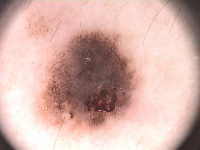</td><td>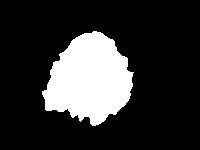</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2024-08-15 18:44:43--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2024-08-15 18:44:44--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc326978f2b9a9f0e0d8ad512590.dl.dropboxusercontent.com/cd/0/inline/CYsuvVSEUxoqCnOQx02yuR_W9sibxzMSV4Ty3IEwAhZ1maA0YBQGijDacd7c27porgK3pQ9qzC5Lu9FfT44CkBqNib_zZOMgsMS_UgEXPESGR5HlHnpRJ3VQPCv6u7lgM8E/file# [following]
--2024-08-15 18:44:44--  https://uc326978f2b9a9f0e0d8ad512590.dl.dropboxusercontent.com/cd/0/inline/CYsuvVSEUxoqC

In [1]:
!ls

'[hw]semantic_segmentation.ipynb'   PH2Dataset	 PH2Dataset.rar


In [1]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

zsh:1: command not found: unrar


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

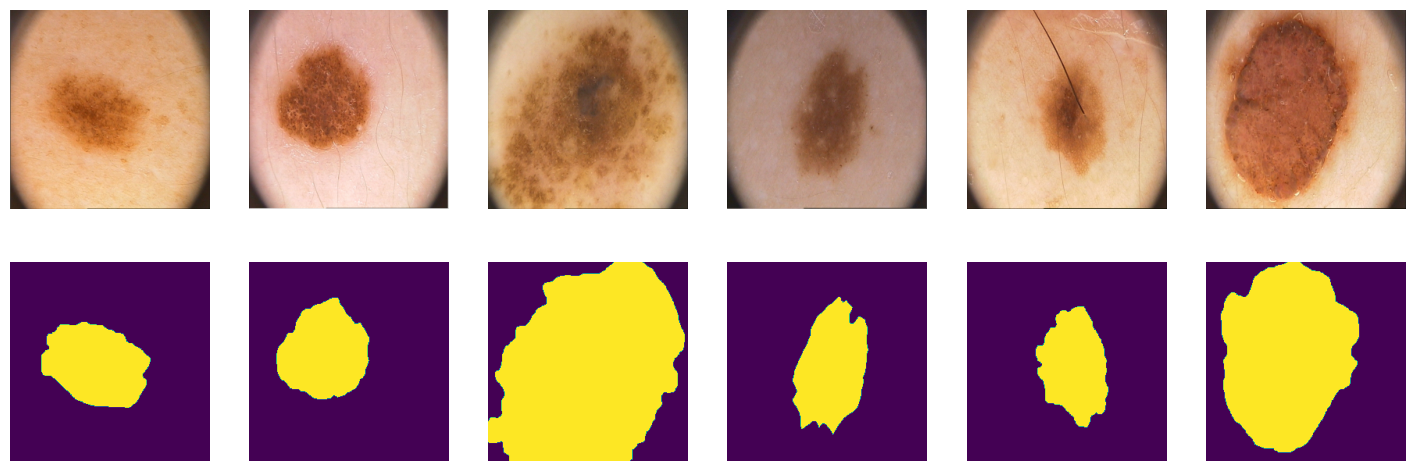

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

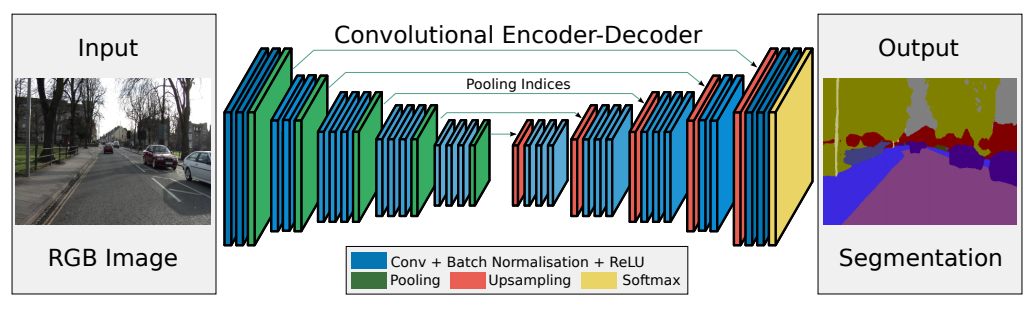

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
import collections

rcParams['figure.figsize'] = (15,4)

In [12]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), #256x256x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d((2, 2)) #128x128x8
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1), #128x128x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d((2, 2)) #64x64x8
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1), #64x64x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d((2, 2)) #32x32x16
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1), #32x32x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d((2, 2)) #16x16x16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1) #16x16x16

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) #32x32x16
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1), #32x32x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2) #64x64x16
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(16, 8, 3, padding=1), #64x64x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.upsample2 = nn.Upsample(scale_factor=2) #128x128x8
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1), #128x128x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2) #256x256x8
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(8, 1, 3, padding=1), #256x256x2
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [13]:
from torchmetrics.classification import BinaryJaccardIndex

iou = BinaryJaccardIndex()

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [14]:
def bce_loss(y_pred, y_real):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-1 * y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [15]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device).squeeze(1)
    
            # set parameter gradients to zero
            opt.zero_grad()
            
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred.squeeze(1), Y_batch) # forward-pass

            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(Y_batch)

        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()# detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [16]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [17]:
import torch.nn.functional as F

def score_model(model, metric, data):
    metric = metric.to(device)
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred = F.sigmoid(Y_pred)
        Y_pred = Y_pred > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [18]:
max_epochs = 40

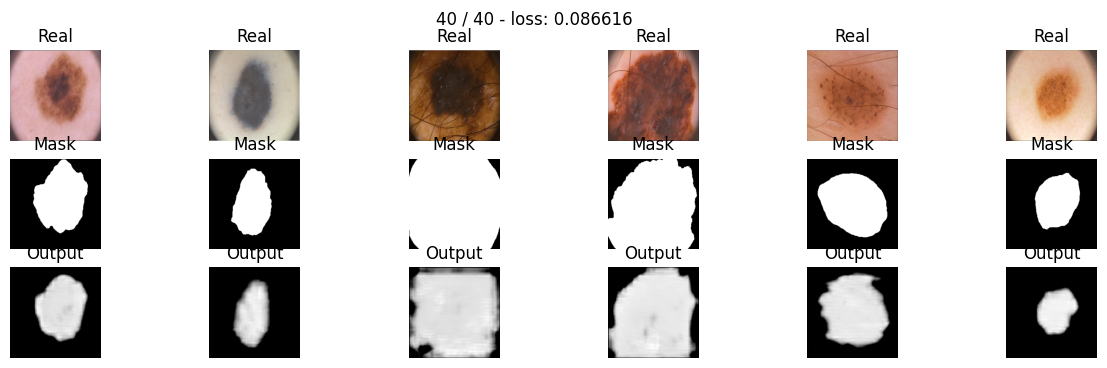

In [19]:
segnet_model_bce = SegNet().to(device)
optimizer = torch.optim.Adam(segnet_model_bce.parameters(), lr=1e-3)
train(segnet_model_bce, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [20]:
!rm -rf logs

from catalyst import dl

loaders = {
    "train": data_tr,
    "valid": data_val,
}

In [21]:
segnet_model_bce = SegNet()
optimizer = torch.optim.Adam(segnet_model_bce.parameters(), lr=1e-3)

runner = dl.SupervisedRunner()

runner.train(
    engine=dl.GPUEngine(),
    model=segnet_model_bce,
    optimizer=optimizer,
    criterion=bce_loss,
    logdir="./logs/segnet_bce",
    loaders=loaders,
    verbose=False,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=max_epochs,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="logits", target_key="targets", threshold=0.5)
    ]
)

/home/dmitry/Documents/programming/study/ml/venv/lib/python3.12/site-packages/accelerate/utils/dataclasses.py:480: FutureWarning: The `TPU` of `<enum 'DistributedType'>` is deprecated and will be removed in v1.0.0. Please use the `XLA` instead.
  warnings.warn(


train (1/40) iou: 0.38734763860702515 | iou/_macro: 0.38734763860702515 | iou/_micro: 0.38734763860702515 | loss: 0.7022895365953445 | loss/mean: 0.7022895365953445 | loss/std: 0.06634867372089215 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.7040114104747772 | loss/mean: 0.7040114104747772 | loss/std: 0.0010801334126588336 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.6459592580795288 | iou/_macro: 0.6459592580795288 | iou/_micro: 0.6459592580795288 | loss: 0.6022012680768967 | loss/mean: 0.6022012680768967 | loss/std: 0.020504887398046314 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.7021218836307526 | loss/mean: 0.7021218836307526 | loss/std: 0.0005152452230456796 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.6795422434806824 | iou/_macro: 0.6795422434806824 | iou/_micro: 0.6795422434806824 | loss: 0.5854405760765076 | loss/mean: 0.5854405760765076 

In [22]:
score_model(segnet_model_bce, iou, data_ts)

0.7357185184955597

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [23]:
def dice_loss(y_real, y_pred):
    smooth = 1e-6
    intersection = torch.sum(y_real * y_pred)
    union = torch.sum(y_real) + torch.sum(y_pred)
    dice_score = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice_score

Проводим тестирование:

In [24]:
segnet_model_dice = SegNet()
optimizer = torch.optim.Adam(segnet_model_dice.parameters(), lr=1e-3)

runner = dl.SupervisedRunner()

runner.train(
    engine=dl.GPUEngine(),
    model=segnet_model_dice,
    optimizer=optimizer,
    criterion=dice_loss,
    logdir="./logs/segnet_dice",
    loaders=loaders,
    verbose=False,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=max_epochs,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="logits", target_key="targets", threshold=0.5)
    ]
)

train (1/40) iou: 0.3357502222061157 | iou/_macro: 0.3357502222061157 | iou/_micro: 0.3357502222061157 | loss: 0.4787636697292328 | loss/mean: 0.4787636697292328 | loss/std: 0.16060813936899224 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.873706191778183 | loss/mean: 0.873706191778183 | loss/std: 0.0015099710576863656 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.5601807832717896 | iou/_macro: 0.5601807832717896 | iou/_micro: 0.5601807832717896 | loss: 0.10610225796699524 | loss/mean: 0.10610225796699524 | loss/std: 0.059644063259052894 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.8261195421218872 | loss/mean: 0.8261195421218872 | loss/std: 0.00735980310653949 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.6265341639518738 | iou/_macro: 0.6265341639518738 | iou/_micro: 0.6265341639518738 | loss: -0.027688264846801758 | loss/mean: -0.027688264846801758

In [25]:
score_model(segnet_model_dice, iou, data_ts)

0.6998715698719025

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [26]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    return -1 * torch.mean(torch.pow(1 - torch.sigmoid(y_pred), gamma) * y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred)))


In [27]:
segnet_model_focal = SegNet()
optimizer = torch.optim.Adam(segnet_model_focal.parameters(), lr=1e-3)

runner = dl.SupervisedRunner()

runner.train(
    engine=dl.GPUEngine(),
    model=segnet_model_focal,
    optimizer=optimizer,
    criterion=focal_loss,
    logdir="./logs/segnet_focal",
    loaders=loaders,
    verbose=False,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=max_epochs,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="logits", target_key="targets", threshold=0.5)
    ]
)

train (1/40) iou: 0.2611198425292969 | iou/_macro: 0.2611198425292969 | iou/_micro: 0.2611198425292969 | loss: 0.5844866931438446 | loss/mean: 0.5844866931438446 | loss/std: 0.048177613461642226 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.818459540605545 | loss/mean: 0.818459540605545 | loss/std: 0.01161708637951669 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.5602123737335205 | iou/_macro: 0.5602123737335205 | iou/_micro: 0.5602123737335205 | loss: 0.43798136711120605 | loss/mean: 0.43798136711120605 | loss/std: 0.011626886758617571 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.7483363747596741 | loss/mean: 0.7483363747596741 | loss/std: 0.022192122034493316 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.6407192945480347 | iou/_macro: 0.6407192945480347 | iou/_micro: 0.6407192945480347 | loss: 0.3866409584879875 | loss/mean: 0.3866409584879875 | los

In [28]:
score_model(segnet_model_focal, iou, data_ts)

0.7396901845932007

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [29]:
def tversky_loss(y_real, y_pred, gamma=0.7):
    alpha = gamma
    beta = 1 - gamma
    
    numerator = torch.sum(y_real * y_pred)
    denominator = numerator + alpha * torch.sum((1 - y_real) * y_pred) + beta * torch.sum(y_real * (1 - y_pred))
    
    return 1 - (numerator / denominator)

In [30]:
segnet_model_tversky = SegNet()
optimizer = torch.optim.Adam(segnet_model_tversky.parameters(), lr=1e-3)

runner = dl.SupervisedRunner()

runner.train(
    engine=dl.GPUEngine(),
    model=segnet_model_tversky,
    optimizer=optimizer,
    criterion=tversky_loss,
    logdir="./logs/segnet_tversky",
    loaders=loaders,
    verbose=False,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=max_epochs,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="logits", target_key="targets", threshold=0.5)
    ]
)

train (1/40) iou: 0.3344855010509491 | iou/_macro: 0.3344855010509491 | iou/_micro: 0.3344855010509491 | loss: 0.4643218219280243 | loss/mean: 0.4643218219280243 | loss/std: 0.1738986341108423 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.8974055647850037 | loss/mean: 0.8974055647850037 | loss/std: 0.00048173847847951876 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.5682164430618286 | iou/_macro: 0.5682164430618286 | iou/_micro: 0.5682164430618286 | loss: 0.07028648257255554 | loss/mean: 0.07028648257255554 | loss/std: 0.04425213689029669 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.8517484068870544 | loss/mean: 0.8517484068870544 | loss/std: 0.0032587341170787396 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.645561695098877 | iou/_macro: 0.645561695098877 | iou/_micro: 0.645561695098877 | loss: -0.06992480158805847 | loss/mean: -0.06992480158805847 |

In [31]:
score_model(segnet_model_tversky, iou, data_ts)

0.7240062952041626

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

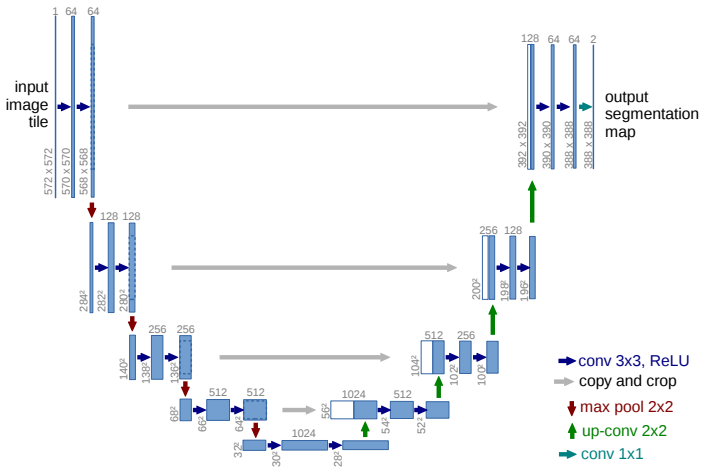

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [32]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), #256x256x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d((2, 2)) #128x128x8
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1), #128x128x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d((2, 2)) #64x64x8
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1), #64x64x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d((2, 2)) #32x32x16
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1), #32x32x16
        
        )
        self.pool3 = nn.MaxPool2d((2, 2)) #16x16x16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1) #16x16x16

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) #32x32x16
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1), #32x32x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2) #64x64x16
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(32, 8, 3, padding=1), #64x64x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.upsample2 = nn.Upsample(scale_factor=2) #128x128x8
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(16, 8, 3, padding=1), #128x128x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2) #256x256x8
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(16, 1, 3, padding=1), #256x256x2
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.cat([b, e3], 1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat([d0, e2], 1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat([d1, e1], 1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat([d2, e0], 1)))
        return d3

In [33]:
unet_model_focal = UNet()
optimizer = torch.optim.Adam(unet_model_focal.parameters(), lr=1e-3)

runner = dl.SupervisedRunner()

runner.train(
    engine=dl.GPUEngine(),
    model=unet_model_focal,
    optimizer=optimizer,
    criterion=focal_loss,
    logdir="./logs/unet_focal",
    loaders=loaders,
    verbose=False,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=max_epochs,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="logits", target_key="targets", threshold=0.5)
    ]
)

train (1/40) iou: 0.5714049935340881 | iou/_macro: 0.5714049935340881 | iou/_micro: 0.5714049935340881 | loss: 0.4382941350340843 | loss/mean: 0.4382941350340843 | loss/std: 0.03806501041944689 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.8833419680595398 | loss/mean: 0.8833419680595398 | loss/std: 0.012912048300013908 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.6793932914733887 | iou/_macro: 0.6793932914733887 | iou/_micro: 0.6793932914733887 | loss: 0.37750035524368286 | loss/mean: 0.37750035524368286 | loss/std: 0.004538244564142811 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.8833033740520477 | loss/mean: 0.8833033740520477 | loss/std: 0.029481449589344233 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.7044289708137512 | iou/_macro: 0.7044289708137512 | iou/_micro: 0.7044289708137512 | loss: 0.3582858070731163 | loss/mean: 0.3582858070731163 | l

In [34]:
score_model(unet_model_focal, iou, data_ts)

0.7568694949150085

In [35]:
unet_model_bce = UNet()
optimizer = torch.optim.Adam(unet_model_bce.parameters(), lr=1e-3)

runner = dl.SupervisedRunner()

runner.train(
    engine=dl.GPUEngine(),
    model=unet_model_bce,
    optimizer=optimizer,
    criterion=bce_loss,
    logdir="./logs/unet_bce",
    loaders=loaders,
    verbose=False,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=max_epochs,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="logits", target_key="targets", threshold=0.5)
    ]
)

train (1/40) iou: 0.587043285369873 | iou/_macro: 0.587043285369873 | iou/_micro: 0.587043285369873 | loss: 0.6228142976760864 | loss/mean: 0.6228142976760864 | loss/std: 0.019593554862658548 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.6931281685829163 | loss/mean: 0.6931281685829163 | loss/std: 2.6251465643928282e-05 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.6779877543449402 | iou/_macro: 0.6779877543449402 | iou/_micro: 0.6779877543449402 | loss: 0.5845426768064499 | loss/mean: 0.5845426768064499 | loss/std: 0.011610373870814001 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.693148672580719 | loss/mean: 0.693148672580719 | loss/std: 3.6125870152194884e-07 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.6865254640579224 | iou/_macro: 0.6865254640579224 | iou/_micro: 0.6865254640579224 | loss: 0.5796364396810532 | loss/mean: 0.5796364396810532 | los

In [36]:
score_model(unet_model_bce, iou, data_ts)

0.7493332028388977

In [37]:
unet_model_tversky = UNet()
optimizer = torch.optim.Adam(unet_model_tversky.parameters(), lr=1e-3)

runner = dl.SupervisedRunner()

runner.train(
    engine=dl.GPUEngine(),
    model=unet_model_tversky,
    optimizer=optimizer,
    criterion=tversky_loss,
    logdir="./logs/unet_tversky",
    loaders=loaders,
    verbose=False,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=max_epochs,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="logits", target_key="targets", threshold=0.5)
    ]
)

train (1/40) iou: 0.5792130827903748 | iou/_macro: 0.5792130827903748 | iou/_micro: 0.5792130827903748 | loss: 0.06399506330490112 | loss/mean: 0.06399506330490112 | loss/std: 0.10096631685934222 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.9987674355506897 | loss/mean: 0.9987674355506897 | loss/std: 0.0007005408320346458 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.6676721572875977 | iou/_macro: 0.6676721572875977 | iou/_micro: 0.6676721572875977 | loss: -0.08244684338569641 | loss/mean: -0.08244684338569641 | loss/std: 0.034689095968329656 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.9999981820583344 | loss/mean: 0.9999981820583344 | loss/std: 8.128320784243849e-07 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.6799201965332031 | iou/_macro: 0.6799201965332031 | iou/_micro: 0.6799201965332031 | loss: -0.11282917857170105 | loss/mean: -0.11282917857

In [38]:
score_model(unet_model_tversky, iou, data_ts)

0.745692253112793

In [39]:
unet_model_dice = UNet()
optimizer = torch.optim.Adam(unet_model_dice.parameters(), lr=1e-3)

runner = dl.SupervisedRunner()

runner.train(
    engine=dl.GPUEngine(),
    model=unet_model_dice,
    optimizer=optimizer,
    criterion=dice_loss,
    logdir="./logs/unet_dice",
    loaders=loaders,
    verbose=False,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=max_epochs,
    callbacks=[
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.IOUCallback(input_key="logits", target_key="targets", threshold=0.5)
    ]
)

train (1/40) iou: 0.5766291618347168 | iou/_macro: 0.5766291618347168 | iou/_micro: 0.5766291618347168 | loss: 0.09085097908973694 | loss/mean: 0.09085097908973694 | loss/std: 0.08730951104673351 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.9968147277832031 | loss/mean: 0.9968147277832031 | loss/std: 0.0015403468935060029 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.6538740992546082 | iou/_macro: 0.6538740992546082 | iou/_micro: 0.6538740992546082 | loss: -0.039698243141174316 | loss/mean: -0.039698243141174316 | loss/std: 0.016400301150032163 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.9999816417694092 | loss/mean: 0.9999816417694092 | loss/std: 1.505244589674787e-06 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.6605116724967957 | iou/_macro: 0.6605116724967957 | iou/_micro: 0.6605116724967957 | loss: -0.06267668306827545 | loss/mean: -0.062676683

In [40]:
score_model(unet_model_dice, iou, data_ts)

0.7389997243881226

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [41]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1, stride=2), #256x256x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1, stride=2), #128x128x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, stride=2), #64x64x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, stride=2), #32x32x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1) #16x16x16

        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, padding=1, stride=2, output_padding=1), #32x32x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(32, 8, 3, padding=1, stride=2, output_padding=1), #64x64x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, padding=1, stride=2, output_padding=1), #128x128x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, 3, padding=1, stride=2, output_padding=1), #256x256x2
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)

        # bottleneck
        b = self.bottleneck_conv(e3)
        
        # decoder
        d0 = self.dec_conv0(torch.cat([b, e3], 1))
        d1 = self.dec_conv1(torch.cat([d0, e2], 1))
        d2 = self.dec_conv2(torch.cat([d1, e1], 1))
        d3 = self.dec_conv3(torch.cat([d2, e0], 1))
        return d3

In [42]:
runner = dl.SupervisedRunner()

unet2_model_focal = UNet2()
optimizer = torch.optim.Adam(unet2_model_focal.parameters(), lr=1e-3)

runner.train(
        engine=dl.GPUEngine(),
        model=unet2_model_focal,
        criterion=focal_loss,
        optimizer=optimizer,
        loaders=loaders,
        logdir="./logs/unet2_focal",
        num_epochs=max_epochs,
        verbose=False,
        callbacks=[
            dl.CriterionCallback(input_key='logits', target_key="targets", metric_key="loss"),
            dl.BackwardCallback(metric_key="loss"),
            dl.OptimizerCallback(metric_key="loss"),
            dl.IOUCallback(input_key='logits', target_key="targets", threshold=0.5)
        ],
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
)

train (1/40) iou: 0.25176331400871277 | iou/_macro: 0.25176331400871277 | iou/_micro: 0.25176331400871277 | loss: 0.5735192149877548 | loss/mean: 0.5735192149877548 | loss/std: 0.029229173302916564 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 9.949802688424825e-07 | iou/_macro: 9.949802688424825e-07 | iou/_micro: 9.949802688424825e-07 | loss: 0.7918127179145813 | loss/mean: 0.7918127179145813 | loss/std: 0.007748698098727868 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.33500292897224426 | iou/_macro: 0.33500292897224426 | iou/_micro: 0.33500292897224426 | loss: 0.5172192752361298 | loss/mean: 0.5172192752361298 | loss/std: 0.006146486108533286 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.863122820854187 | loss/mean: 0.863122820854187 | loss/std: 0.029830576019473403 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.388184517621994 | iou/_macro: 0.388184517621994 | iou/_micro: 0.388184517621994 | loss: 

In [43]:
score_model(unet2_model_focal, iou, data_ts)

0.6768912076950073

In [44]:
runner = dl.SupervisedRunner()

unet2_model_tversky = UNet2()
optimizer = torch.optim.Adam(unet2_model_tversky.parameters(), lr=1e-3)

runner.train(
        engine=dl.GPUEngine(),
        model=unet2_model_tversky,
        criterion=tversky_loss,
        optimizer=optimizer,
        loaders=loaders,
        logdir="./logs/unet2_tversky",
        num_epochs=max_epochs,
        verbose=False,
        callbacks=[
            dl.CriterionCallback(input_key='logits', target_key="targets", metric_key="loss"),
            dl.BackwardCallback(metric_key="loss"),
            dl.OptimizerCallback(metric_key="loss"),
            dl.IOUCallback(input_key='logits', target_key="targets", threshold=0.5)
        ],
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
)

train (1/40) iou: 0.2518455982208252 | iou/_macro: 0.2518455982208252 | iou/_micro: 0.2518455982208252 | loss: 0.4535399079322815 | loss/mean: 0.4535399079322815 | loss/std: 0.08101835740133977 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.8443253636360168 | loss/mean: 0.8443253636360168 | loss/std: 0.00746787966807814 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.33125078678131104 | iou/_macro: 0.33125078678131104 | iou/_micro: 0.33125078678131104 | loss: 0.28901252150535583 | loss/mean: 0.28901252150535583 | loss/std: 0.03306266134234609 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.9617699384689331 | loss/mean: 0.9617699384689331 | loss/std: 0.003690980153449751 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.3822293281555176 | iou/_macro: 0.3822293281555176 | iou/_micro: 0.3822293281555176 | loss: 0.19005310535430908 | loss/mean: 0.19005310535430908 

In [45]:
score_model(unet2_model_tversky, iou, data_ts)

0.6374902725219727

In [46]:
runner = dl.SupervisedRunner()

unet2_model_bce = UNet2()
optimizer = torch.optim.Adam(unet2_model_bce.parameters(), lr=1e-3)

runner.train(
        engine=dl.GPUEngine(),
        model=unet2_model_bce,
        criterion=bce_loss,
        optimizer=optimizer,
        loaders=loaders,
        logdir="./logs/unet2_bce",
        num_epochs=max_epochs,
        verbose=False,
        callbacks=[
            dl.CriterionCallback(input_key='logits', target_key="targets", metric_key="loss"),
            dl.BackwardCallback(metric_key="loss"),
            dl.OptimizerCallback(metric_key="loss"),
            dl.IOUCallback(input_key='logits', target_key="targets", threshold=0.5)
        ],
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
)

train (1/40) iou: 0.25000059604644775 | iou/_macro: 0.25000059604644775 | iou/_micro: 0.25000059604644775 | loss: 0.7415284365415573 | loss/mean: 0.7415284365415573 | loss/std: 0.02285289935617109 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.7232547700405121 | loss/mean: 0.7232547700405121 | loss/std: 0.0022016008417501368 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.31731095910072327 | iou/_macro: 0.31731095910072327 | iou/_micro: 0.31731095910072327 | loss: 0.6880627125501633 | loss/mean: 0.6880627125501633 | loss/std: 0.024200917372416145 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.701483279466629 | loss/mean: 0.701483279466629 | loss/std: 0.0014111065930365256 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.35333892703056335 | iou/_macro: 0.35333892703056335 | iou/_micro: 0.35333892703056335 | loss: 0.660537526011467 | loss/mean: 0.66053752601146

In [47]:
score_model(unet2_model_bce, iou, data_ts)

0.65631502866745

In [48]:
runner = dl.SupervisedRunner()

unet2_model_dice = UNet2()
optimizer = torch.optim.Adam(unet2_model_dice.parameters(), lr=1e-3)

runner.train(
        engine=dl.GPUEngine(),
        model=unet2_model_dice,
        criterion=dice_loss,
        optimizer=optimizer,
        loaders=loaders,
        logdir="./logs/unet2_dice",
        num_epochs=max_epochs,
        verbose=False,
        callbacks=[
            dl.CriterionCallback(input_key='logits', target_key="targets", metric_key="loss"),
            dl.BackwardCallback(metric_key="loss"),
            dl.OptimizerCallback(metric_key="loss"),
            dl.IOUCallback(input_key='logits', target_key="targets", threshold=0.5)
        ],
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
)

train (1/40) iou: 0.2513377368450165 | iou/_macro: 0.2513377368450165 | iou/_micro: 0.2513377368450165 | loss: 0.45741915702819824 | loss/mean: 0.45741915702819824 | loss/std: 0.0769247077141151 | lr: 0.001 | momentum: 0.9
valid (1/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.8123706579208374 | loss/mean: 0.8123706579208374 | loss/std: 0.00999169316669406 | lr: 0.001 | momentum: 0.9
* Epoch (1/40) 
train (2/40) iou: 0.3276214003562927 | iou/_macro: 0.3276214003562927 | iou/_micro: 0.3276214003562927 | loss: 0.2947605103254318 | loss/mean: 0.2947605103254318 | loss/std: 0.04483386413230089 | lr: 0.001 | momentum: 0.9
valid (2/40) iou: 0.0 | iou/_macro: 0.0 | iou/_micro: 0.0 | loss: 0.9440717399120331 | loss/mean: 0.9440717399120331 | loss/std: 0.005047055004287767 | lr: 0.001 | momentum: 0.9
* Epoch (2/40) 
train (3/40) iou: 0.37494567036628723 | iou/_macro: 0.37494567036628723 | iou/_micro: 0.37494567036628723 | loss: 0.1992742121219635 | loss/mean: 0.1992742121219635 | l

In [49]:
score_model(unet2_model_dice, iou, data_ts)

0.6392472982406616

In [50]:
%load_ext tensorboard
%tensorboard --logdir logs

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.